In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

from einops import rearrange, reduce, repeat

import itertools
from tqdm import tqdm


## TODO

* random init seed
* LR-dependent fudge factor for jump times?
* longer costmin times in GD; instantaneous in AGF. Wider nets mask this discrepancy

# Library

In [2]:
class ImageData():
    """
    Get image datasets as numpy arrays.
    """

    dataset_dict = {
        'mnist': torchvision.datasets.MNIST,
        'fmnist': torchvision.datasets.FashionMNIST,
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar100': torchvision.datasets.CIFAR100,
        'svhn': torchvision.datasets.SVHN,
        'imagenet32': None,
        'imagenet64': None,
    }

    def __init__(self, dataset_name, data_dir, classes=None, onehot=True):
        """
        dataset_name (str): one of  'mnist', 'fmnist', 'cifar10', 'cifar100', 'imagenet32', 'imagenet64'
        dataset_dir (str): the directory where the raw dataset is saved
        classes (iterable): a list of groupings of old class labels that each constitute a new class.
            e.g. [[0,1], [8]] on MNIST would be a binary classification problem where the first class
            consists of samples of 0's and 1's and the second class has samples of 8's
        onehot (boolean): whether to use one-hot label encodings (typical for MSE loss). Default: True
        format (str): specify order of (sample, channel, height, width) dims. 'NCHW' default, or 'NHWC.'
            torchvision.dataset('cifar10') uses latter, needs ToTensor transform to reshape; former is ready-to-use.

        returns: numpy ndarray with shape (b, c, h, w)
        """

        assert dataset_name in self.dataset_dict
        self.name = dataset_name

        def format_data(dataset):
            if self.name in ['cifar10','cifar100']:
                X, y = dataset.data, dataset.targets
                X = rearrange(X, 'b h w c -> b c h w')
                y = np.array(y)
            if self.name in ['mnist', 'fmnist']:
                X, y = dataset.data.numpy(), dataset.targets.numpy()
                X = rearrange(X, 'b h w -> b 1 h w')
            if self.name in ['svhn']:
                X, y = dataset.data, dataset.labels
            if self.name in ['imagenet32', 'imagenet64']:
                X, y = dataset['data'], dataset['labels']
                X = rearrange(X, 'b d -> b c h w', c=3, h=32, w=32)
                y -= 1

            if classes is not None:
                # convert old class labels to new
                converter = -1 * np.ones(int(max(y)) + 1)
                for new_class, group in enumerate(classes):
                    group = [group] if type(group) == int else group
                    for old_class in group:
                        converter[old_class] = new_class
                # remove datapoints not in new classes
                mask = (converter[y] >= 0)
                X = X[mask]
                y = converter[y][mask]

            # make elements of input O(1)
            X = X/255.0
            # shape labels (N, nclasses)
            y = F.one_hot(torch.Tensor(y).long()).numpy() if onehot else y[:, None]

            return X.astype(np.float32), y.astype(np.float32)

        if self.name in ['cifar10','cifar100', 'mnist', 'fmnist']:
            raw_train = self.dataset_dict[self.name](root=data_dir, train=True, download=True)
            raw_test = self.dataset_dict[self.name](root=data_dir, train=False, download=True)
        if self.name == 'svhn':
            raw_train = self.dataset_dict[self.name](root=data_dir, split='train', download=True)
            raw_test = self.dataset_dict[self.name](root=data_dir, split='test', download=True)
        if self.name in ['imagenet32', 'imagenet64']:
            raw_train = np.load(f"{data_dir}/{self.name}-val.npz")
            raw_test = np.load(f"{data_dir}/{self.name}-val.npz")

        # process raw datasets
        self.train_X, self.train_y = format_data(raw_train)
        self.test_X, self.test_y = format_data(raw_test)

    def get_dataset(self, n, get="train", rng=None):
        """Generate an image dataset.

        n (int): the dataset size
        rng (numpy RNG): numpy RNG state for random sampling. Default: None
        get (str): either "train" or "test." Default: "train"

        Returns: tuple (X, y) such that X.shape = (n, *in_shape), y.shape = (n, *out_shape)
        """

        assert int(n) == n
        n = int(n)
        assert n > 0
        assert get in ["train", "test"]
        full_X, full_y = (self.train_X, self.train_y) if get == "train" else (self.test_X, self.test_y)

        # get subset
        idxs = slice(n) if rng is None else rng.choice(len(full_X), size=n, replace=False)
        X, y = full_X[idxs].copy(), full_y[idxs].copy()
        assert len(X) == n
        return X, y

In [3]:
class ExptTrace():

    @classmethod
    def multi_init(cls, num_init, var_names):
        return [cls(var_names) for _ in range(num_init)]

    def __init__(self, var_names):
        assert "val" not in var_names, f"variable name 'val' disallowed"
        self.var_names = var_names
        self.vals = {}
        self.valshape = None

    def __setitem__(self, key, val):
        if self.valshape is None:
            self.valshape = np.shape(val)
        assert np.shape(val) == self.valshape, f"value shape {np.shape(val)} != expected {self.valshape}"
        key = tuple((key,)) if not isinstance(key, tuple) else key
        assert len(key) == len(self.var_names), f"num keys {len(key)} != num vars {len(self.var_names)}"
        assert key not in self.vals, f"key {key} already exists. overwriting not supported"
        self.vals[key] = val

    def __getitem__(self, key):
        assert self.valshape is not None, "must add items before getting"
        key = tuple((key,)) if not isinstance(key, tuple) else key
        assert len(key) == len(self.var_names), f"num keys {len(key)} != num vars {len(self.var_names)}"
        key_axes = []
        for idx, var_name in enumerate(self.var_names):
            key_i = key[idx]
            key_idx_extent = [key_i]
            if isinstance(key_i, slice):
                slice_is_full = all([x==None for x in [key_i.start, key_i.stop, key_i.step]])
                assert slice_is_full, f"slice start/stop/step not supported ({var_name})"
                key_idx_extent = self.get_axis(var_name)
            key_axes.append(key_idx_extent)
        shape = [len(key_idx_extent) for key_idx_extent in key_axes]
        if np.prod(shape) == 1:
            assert key in self.vals, f"key {key} not found"
            return self.vals[key]
        vals = np.zeros(shape + list(self.valshape))

        idx_maps = []
        for axis in key_axes:
            idx_maps.append({val: i for i, val in enumerate(axis)})
        for key in itertools.product(*key_axes):
            shape_idxs = tuple(idx_maps[dim][val] for dim, val in enumerate(key))
            assert key in self.vals, f"key {key} not found"
            vals[shape_idxs] = self.vals[key]

        return vals

    def get_axis(self, var_name):
        assert var_name in self.var_names, f"var {var_name} not found"
        idx = self.var_names.index(var_name)
        key_idx_extent = set()
        for keys in self.vals.keys():
            key_idx_extent.add(keys[idx])
        return sorted(list(key_idx_extent))

    def get(self, **kwargs):
        key = self._get_key(_mode='get', **kwargs)
        return self[key]

    def set(self, **kwargs):
        assert "val" in kwargs, f"no val given"
        val = kwargs["val"]
        key = self._get_key(_mode='set', **kwargs)
        self[key] = val

    def is_written(self, **kwargs):
        key = self._get_key(_mode='set', **kwargs)
        return key in self.vals

    def _get_key(self, _mode='set', **kwargs):
        for var_name in self.var_names:
            if _mode == 'set':
                assert var_name in kwargs, f"must specify var {var_name}"
            elif _mode == 'get':
                if var_name not in kwargs:
                    kwargs[var_name] = slice(None, None, None)
            assert kwargs[var_name] is not None, f"var {var_name} cannot be None"
        key = tuple([kwargs[var_name] for var_name in self.var_names])
        return key

    def serialize(self):
        return {
            "var_names": self.var_names,
            "vals": self.vals,
            "valshape": self.valshape
        }

    @classmethod
    def deserialize(cls, data):
        obj = cls(data["var_names"])
        obj.vals = data["vals"]
        obj.valshape = data["valshape"]
        return obj


In [4]:
def get_cifar10_dataset(n_train, n_test, data_dir = 'data_dir', **kwargs):
    classes = kwargs.get("classes", None)
    cifar10 = ImageData('cifar10', data_dir, classes=classes)
    X_train, y_train = cifar10.get_dataset(n_train, get="train")
    X_test, y_test = cifar10.get_dataset(n_test, get="test")
    X_train, y_train, X_test, y_test = [torch.Tensor(t).cuda() for t in (X_train, y_train, X_test, y_test)]

    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    if kwargs.get('grayscale', False):
        X_train = reduce(X_train, 'N (3 s) -> N s', 'mean')
        X_test = reduce(X_test, 'N (3 s) -> N s', 'mean')

    if kwargs.get('center', False):
        X_mean = reduce(X_train, 'N d -> d', 'mean')
        X_train -= X_mean
        X_test -= X_mean

    if kwargs.get('normalize', False):
        X_train /= torch.linalg.norm(X_train, axis=1, keepdims=True)
        X_test /= torch.linalg.norm(X_test, axis=1, keepdims=True)
        if kwargs.get('center', False):
            X_mean = reduce(X_train, 'N d -> d', 'mean')
            X_train -= X_mean
            X_test -= X_mean

    if kwargs.get('whiten', False):
        assert not kwargs.get('normalize', False)

        X_mean = reduce(X_train, 'N d -> d', 'mean')
        X_train -= X_mean
        covar = torch.cov(X_train.T)
        U, S, _ = torch.linalg.svd(covar)
        zca_matrix = U @ torch.diag(1.0 / (torch.sqrt(S) + 1e-5))  @  U.T
        X_train = X_train @ zca_matrix
        X_test = X_test @ zca_matrix

    return X_train, y_train, X_test, y_test

In [5]:
# plt.rc("font", family='stixgeneral', size=14)
# plt.rc("mathtext", fontset='cm')

def style_axes(ax, numyticks=5, numxticks=5):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8)#, labelsize=24)
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8)#, labelsize=24)
    # ax.xaxis.offsetText.set_fontsize(20)
    ax.grid(alpha=0.3)
    # Remove top/right borders and set linewidth
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.5)


In [6]:
def full_error(model, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            d_out = output.shape[1]
            test_loss += F.mse_loss(output, target, reduction='sum').item() / d_out
            pred = output.argmax(dim=1)
            correct += (pred==target.argmax(dim=1)).sum().item()
    test_loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return test_loss, accuracy

In [44]:
class ShallowMLP(nn.Module):

    def __init__(self, d_in=3072, d_out=10, width=3000, init_scale=1):
        super().__init__()
        self.readin = nn.Linear(d_in, width, bias=False)
        self.readout = nn.Linear(width, d_out, bias=False)

        self.init_scale = init_scale
        self.width = width
        self.d_in = d_in

        with torch.no_grad():
            self.readin.weight.normal_(0, init_scale)
            self.readout.weight.normal_(0, init_scale)

    def get_activations(self, x):
        h1 = self.readin(x)
        h2 = self.readout(F.relu(h1))
        return x, h1, h2

    def forward(self, x):
        _, _, h2 = self.get_activations(x)
        return h2


In [20]:
def make_plot(et_train_loss, result=None, fudge_fac=7):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5.1))

    t = et_train_loss.get_axis('nstep')
    train_loss = et_train_loss[:].squeeze()

    ax.plot(t, train_loss, label="relu", color="xkcd:azure", lw=2)
    if result:
        f = utilmax_lr / (lr/(1-mom)) * fudge_fac
        print(f)
        ax.step(f*np.array(result["t"]), np.array(result["losses"]), color="xkcd:azure", lw=2, ls=":",
                marker='o', where="post")

    ax.set_title("solid=GD, dashed=AGF", fontsize=14)

    ax.set_xscale("log")
    ax.set_ylim(0.040, .101)
    ax.set_xlabel('gradient steps')
    ax.set_ylabel('training loss (MSE)')
    ax.legend()
    style_axes(ax)


    plt.tight_layout()
    plt.show()

# Main expt

In [8]:
classes = None
n_train = 10000
n_test = 2000
grayscale = True

DATA_DIR = "~/Documents/datasets" # <- put your dataset dir
X_train, y_train, X_test, y_test = get_cifar10_dataset(n_train, n_test, data_dir=DATA_DIR, classes=classes,
                                                       center=True, normalize=False, grayscale=grayscale)
# mean center labels
y_train -= torch.ones(y_train.shape).cuda() / 10
y_test -= torch.ones(y_test.shape).cuda() / 10

startidx = 2000
X_train = X_train[startidx:startidx+5000]
y_train = y_train[startidx:startidx+5000]

U, S, Vt = torch.linalg.svd(X_train, full_matrices=False)
X_train = U @ Vt * np.sqrt(X_train.shape[0] / X_train.shape[1])
print(f'E[norm(x)] = {torch.linalg.norm(X_train, dim=-1).mean().item():.4f}')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=2000, shuffle=False)

E[norm(x)] = 0.9704


In [91]:
import copy

# Change this back later
width = 5
init_scale = 1e-10
lr = 1
mom = 0.9

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=256, shuffle=True)

ntrials = 1
nepochs = 400

et_train_loss = ExptTrace(["nstep"])

d_in, d_out = X_train.shape[-1], y_train.shape[-1]

model = ShallowMLP(d_in=d_in, d_out=d_out, width=width, init_scale=init_scale).cuda()
model_copy = copy.deepcopy(model.state_dict())

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)
nsteps = 0
for epoch in tqdm(range(nepochs)):
    et_train_loss[nsteps] = full_error(model, train_loader)[0]
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        nsteps += 1

100%|██████████| 400/400 [00:44<00:00,  8.92it/s]


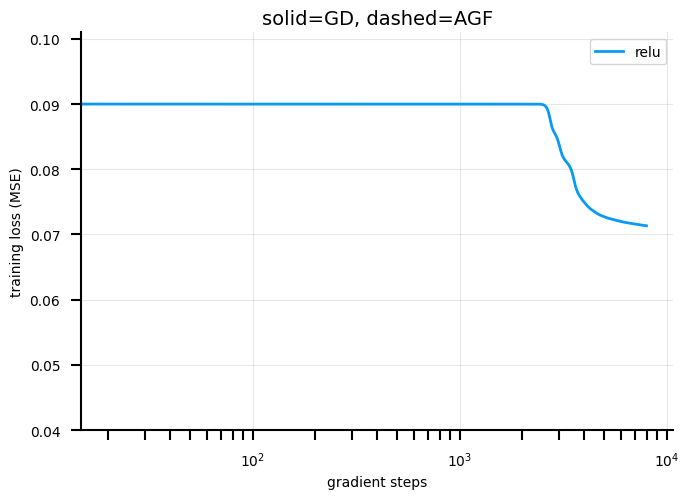

In [92]:
make_plot(et_train_loss)

### AGF

In [93]:
class Neuron(nn.Module):

    def __init__(self, d_in, d_out, nonlin=nn.Identity, init_sz=1):
        super().__init__()
        self.w = nn.Linear(d_in, 1, bias=False)
        self.a = nn.Linear(1, d_out, bias=False)
        with torch.no_grad():
            self.w.weight.mul_(init_sz)
            self.a.weight.mul_(init_sz)
        self.nonlin = nonlin()
        self.active = False
        self.util_acc = 0
        self.c_a = np.log(1/self.get_norm().item()) # is this right?

        self.normalize()

    def forward(self, x):
        return self.a(self.nonlin(self.w(x)))

    def get_norm(self):
        sqnorm = lambda x: torch.linalg.norm(x.weight)**2
        norm = torch.sqrt(sqnorm(self.w) + sqnorm(self.a))
        return norm

    def load_init(self, w, a):
        with torch.no_grad():
            self.w.weight.copy_(w)
            self.a.weight.copy_(a)
        self.c_a = np.log(1/self.get_norm().item()) # is this right?

    def normalize(self):
        norm = self.get_norm()
        with torch.no_grad():
            self.w.weight.div_(norm)
            self.a.weight.div_(norm)

    def utility_step(self, x, residual, learning_rate):
        f_i = self(x)
        util = torch.einsum('nd,nd->n',  f_i, residual).mean()
        self.util_acc += 2 * learning_rate * util.item()

        util.backward()
        with torch.no_grad():
            self.w.weight += learning_rate * self.w.weight.grad
            self.a.weight += learning_rate * self.a.weight.grad
            self.w.weight.grad.zero_()
            self.a.weight.grad.zero_()
            self.normalize()


class Network(nn.Module):

    def __init__(self, d_in, d_out, nonlin=nn.Identity, init_sz=1, width=100):
        super().__init__()
        neurons = [Neuron(d_in, d_out, nonlin, init_sz) for _ in range(width)]
        self.neurons = nn.ModuleList(neurons)
        self.set_mode("utilmax")
        self.d_out = d_out

    def load_init(self, W, A):
        for i, n in enumerate(self.neurons):
            w, a = W[i][None, :], A[:, i][:, None]
            n.load_init(w, a)

    def dormant(self):
        return [neuron for neuron in self.neurons if not neuron.active]

    def active(self):
        return [neuron for neuron in self.neurons if neuron.active]

    def set_mode(self, mode):
        if mode not in ["utilmax", "costmin"]:
            raise ValueError("mode must be utilmax or costmin")
        self.mode = mode
        for neuron in self.neurons:
            grad_on = (mode=="utilmax") ^ neuron.active
            for param in neuron.parameters():
                param.requires_grad = grad_on

    def forward(self, x):
        if not np.any([n.active for n in self.neurons]):
            return torch.zeros(x.shape[0], self.d_out).cuda()
        else:
            outputs = torch.stack([neuron(x) for neuron in self.neurons if neuron.active], dim=0)
            return torch.sum(outputs, dim=0)


def train_agf(X_train, Y_train, init_sz=1e-3, agf_steps=5, nonlin=nn.Identity, load_init=None,
              utilmax_lr=1, costmin_lr=1, costmin_maxiter=2_000, loss_thresh=1e-4):
    # Initialize
    d_in, d_out = X_train.shape[-1], Y_train.shape[-1]
    if load_init:
        W, A = load_init["W"], load_init["A"]
        width = W.shape[0]
        net = Network(d_in, d_out, nonlin, init_sz, width=width).cuda()
        net.load_init(W, A)
    else:
        net = Network(d_in, d_out, nonlin, init_sz, width=agf_steps).cuda()

    def update_results(results, t):
        results["t"].append(t)
        residual = (Y_train - net(X_train))
        residual = residual.detach()
        results["residuals"].append(residual)
        loss = (residual**2).mean().item()
        results["losses"].append(loss)
        results["models"].append(net.state_dict())

    results = {
        "t": [],
        "residuals": [],
        "losses": [],
        "models": [],
    }
    t = 0
    update_results(results, t)
    for _ in tqdm(range(agf_steps)):

        # Utility Maximization
        residual = (1/d_out) * 2*(Y_train - net(X_train))
        residual = residual.detach()
        iters = 0
        mode = "utilmax"
        while mode == "utilmax":
            for n in net.neurons:
                if n.active:
                    continue
                n.utility_step(X_train, residual, utilmax_lr)
                if n.util_acc > n.c_a:
                    n.active = True
                    mode = "costmin"
            iters += 1
        net.set_mode(mode)
        t += iters

        residual = Y_train - net(X_train)
        print(f"loss: {(residual ** 2).mean().item():.5f}")

        # Cost Minimization
        optimizer = torch.optim.SGD(net.parameters(), lr=costmin_lr, momentum=0.9)
        for i in range(int(costmin_maxiter)):
            optimizer.zero_grad(set_to_none=False)
            residual = Y_train - net(X_train)
            loss = (residual ** 2).mean()
            loss.backward()
            optimizer.step()
        net.set_mode("utilmax")
        update_results(results, t)

        if not net.dormant() or loss.item() < loss_thresh:
            print(net.dormant())
            break

    return results

utilmax_lr = 10
init_weights = {
    "W": model_copy["readin.weight"].detach(),
    "A": model_copy["readout.weight"].detach(),
}
result = train_agf(X_train, y_train, init_sz=1e-1, agf_steps=10, nonlin=nn.ReLU, load_init=init_weights,
              utilmax_lr=utilmax_lr, costmin_lr=1, costmin_maxiter=2_000, loss_thresh=1e-4)

  0%|          | 0/10 [00:00<?, ?it/s]

loss: 0.08953


 10%|█         | 1/10 [00:15<02:16, 15.14s/it]

loss: 0.08576


 20%|██        | 2/10 [00:18<01:06,  8.36s/it]

loss: 0.08202


 30%|███       | 3/10 [00:22<00:44,  6.33s/it]

loss: 0.07749


 40%|████      | 4/10 [00:26<00:32,  5.38s/it]

loss: 0.07473


 40%|████      | 4/10 [00:31<00:46,  7.82s/it]

[]


1.0999999999999999


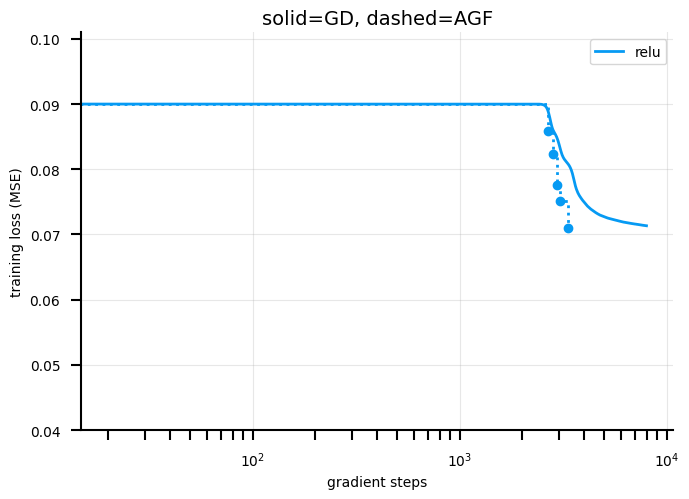

In [94]:
make_plot(et_train_loss, result, fudge_fac=1.1)